In [2]:
%matplotlib inline

from __future__ import print_function

import emcee
import corner
import numpy as np
import scipy.optimize as op
import matplotlib.pyplot as pl
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import pandas as pd

bigfontsize=20
labelfontsize=16
tickfontsize=16
sns.set_context('talk')
pl.rcParams.update({'font.size': bigfontsize,
                     'axes.labelsize':labelfontsize,
                     'xtick.labelsize':tickfontsize,
                     'ytick.labelsize':tickfontsize,
                     'legend.fontsize':tickfontsize,
                     })

//anaconda/envs/astroconda/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [19]:
# Reproducible results!
np.random.seed(123)

# Choose the "true" parameters.
m_true = -0.9594
b_true = 4.294
f_true = 0.534

In [20]:
# Generate some synthetic data from the model.
N = 50
x = np.sort(10*np.random.rand(N))
yerr = 0.1+0.5*np.random.rand(N)
y = m_true*x+b_true
y += np.abs(f_true*y) * np.random.randn(N)
y += yerr * np.random.randn(N)

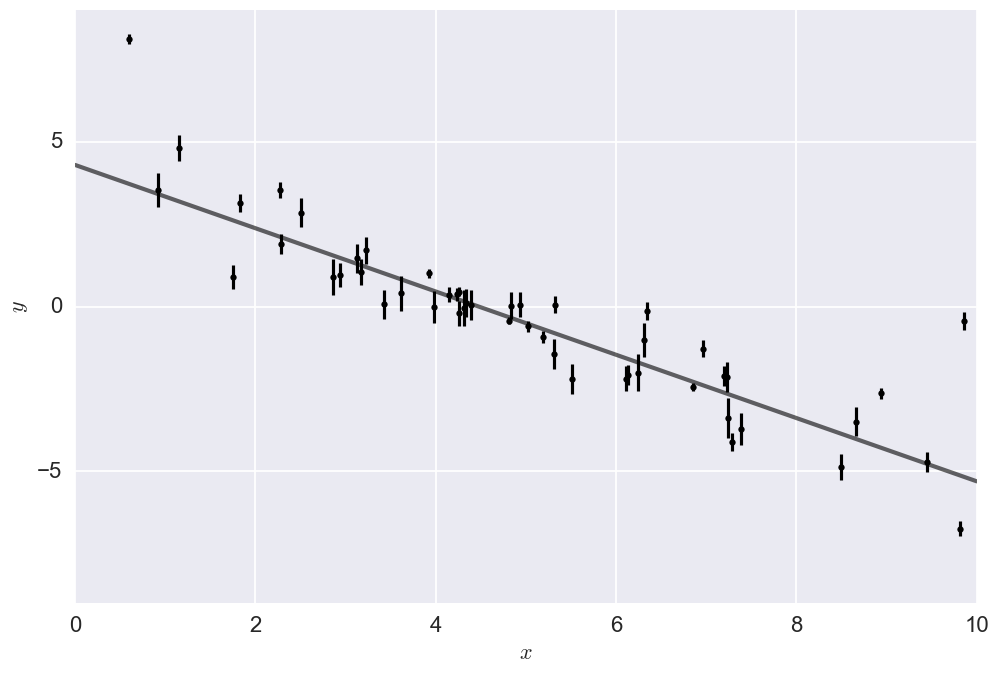

In [21]:
# Plot the dataset and the true model.
xl = np.array([0, 10])
pl.errorbar(x, y, yerr=yerr, fmt=".k")
pl.plot(xl, m_true*xl+b_true, "k", lw=3, alpha=0.6)
pl.ylim(-9, 9)
pl.xlabel("$x$")
pl.ylabel("$y$")
pl.tight_layout()
pl.savefig("line-data.png")

In [22]:
# Do the least-squares fit and compute the uncertainties.
A = np.vstack((np.ones_like(x), x)).T
C = np.diag(yerr * yerr)
cov = np.linalg.inv(np.dot(A.T, np.linalg.solve(C, A)))
b_ls, m_ls = np.dot(cov, np.dot(A.T, np.linalg.solve(C, y)))
print("""Least-squares results:
    m = {0} ± {1} (truth: {2})
    b = {3} ± {4} (truth: {5})
""".format(m_ls, np.sqrt(cov[1, 1]), m_true, b_ls, np.sqrt(cov[0, 0]), b_true))

Least-squares results:
    m = -1.10407570109 ± 0.0162298925523 (truth: -0.9594)
    b = 5.44055525023 ± 0.090908279143 (truth: 4.294)



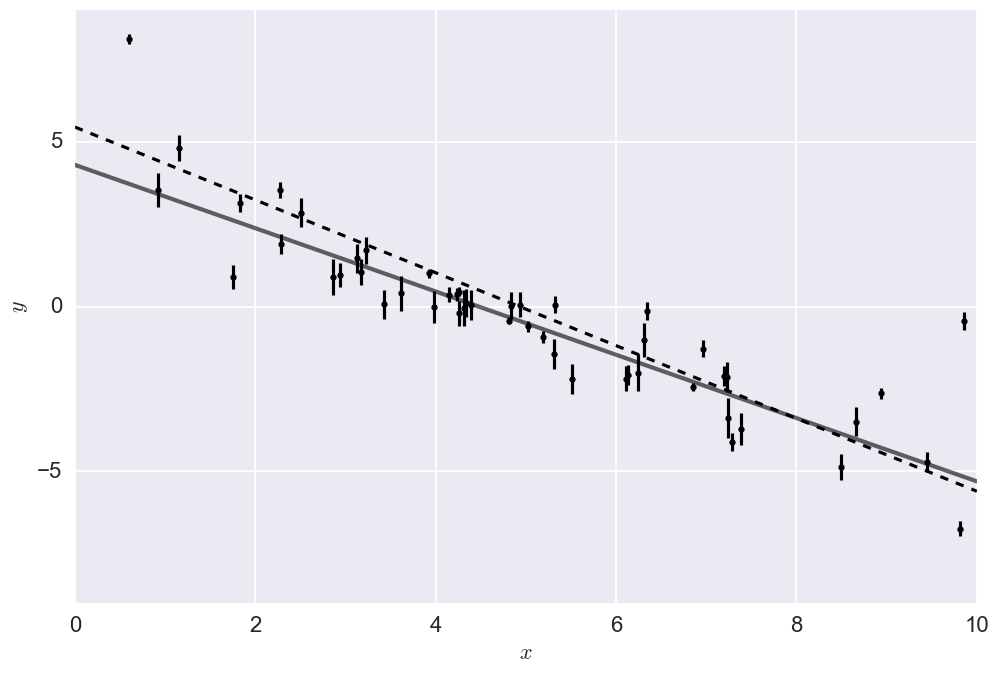

In [23]:
# Plot the least-squares result.
pl.errorbar(x, y, yerr=yerr, fmt=".k")
pl.plot(xl, m_true*xl+b_true, "k", lw=3, alpha=0.6)
pl.ylim(-9, 9)
pl.xlabel("$x$")
pl.ylabel("$y$")
pl.tight_layout()
pl.plot(xl, m_ls*xl+b_ls, "--k")
pl.savefig("line-least-squares.png")

In [24]:
# Define the probability function as likelihood * prior.
def lnprior(theta):
    m, b, lnf = theta
    if -5.0 < m < 0.5 and 0.0 < b < 10.0 and -10.0 < lnf < 1.0:
        return 0.0
    return -np.inf

def lnlike(theta, x, y, yerr):
    m, b, lnf = theta
    model = m * x + b
    inv_sigma2 = 1.0/(yerr**2 + model**2*np.exp(2*lnf))
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(inv_sigma2)))

def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)

In [25]:
# Find the maximum likelihood value.
chi2 = lambda *args: -2 * lnlike(*args)
result = op.minimize(chi2, [m_true, b_true, np.log(f_true)], args=(x, y, yerr))
m_ml, b_ml, lnf_ml = result["x"]
print("""Maximum likelihood result:
    m = {0} (truth: {1})
    b = {2} (truth: {3})
    f = {4} (truth: {5})
""".format(m_ml, m_true, b_ml, b_true, np.exp(lnf_ml), f_true))

Maximum likelihood result:
    m = -1.00300871008 (truth: -0.9594)
    b = 4.52831521378 (truth: 4.294)
    f = 0.45364487085 (truth: 0.534)



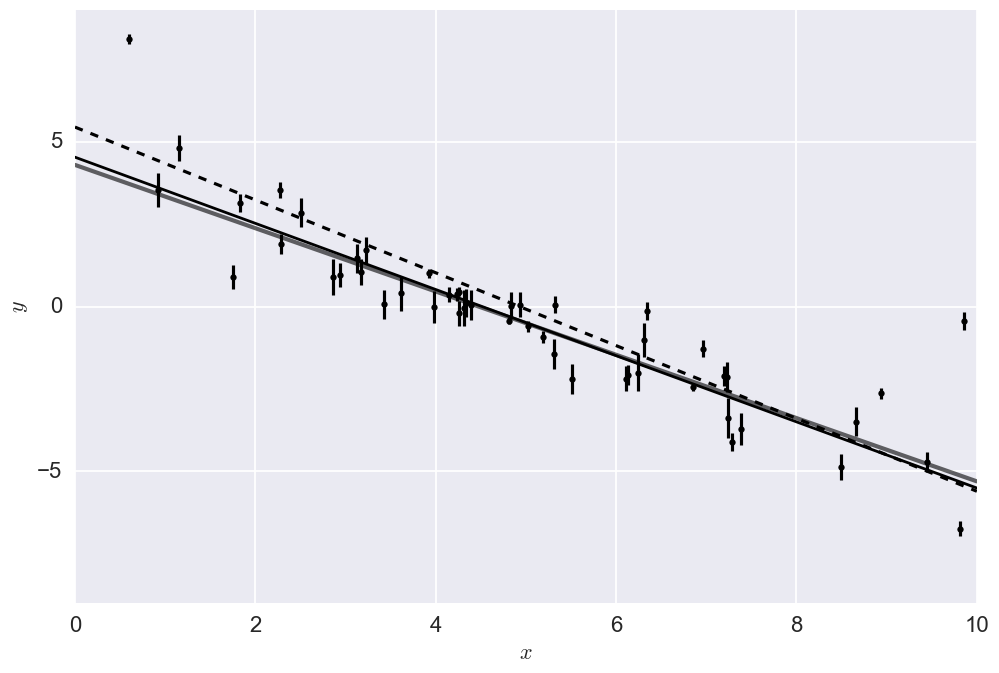

In [26]:
# Plot the maximum likelihood result.
pl.errorbar(x, y, yerr=yerr, fmt=".k")
pl.plot(xl, m_true*xl+b_true, "k", lw=3, alpha=0.6)
pl.ylim(-9, 9)
pl.xlabel("$x$")
pl.ylabel("$y$")
pl.tight_layout()
pl.plot(xl, m_ls*xl+b_ls, "--k")
pl.plot(xl, m_ml*xl+b_ml, "k", lw=2)
pl.savefig("line-max-likelihood.png")

In [27]:
# Set up the sampler.
ndim, nwalkers = 3, 100
pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x, y, yerr))

In [28]:
# Clear and run the production chain.
print("Running MCMC...")
sampler.run_mcmc(pos, 500, rstate0=np.random.get_state())
print("Done.")

Running MCMC...
Done.


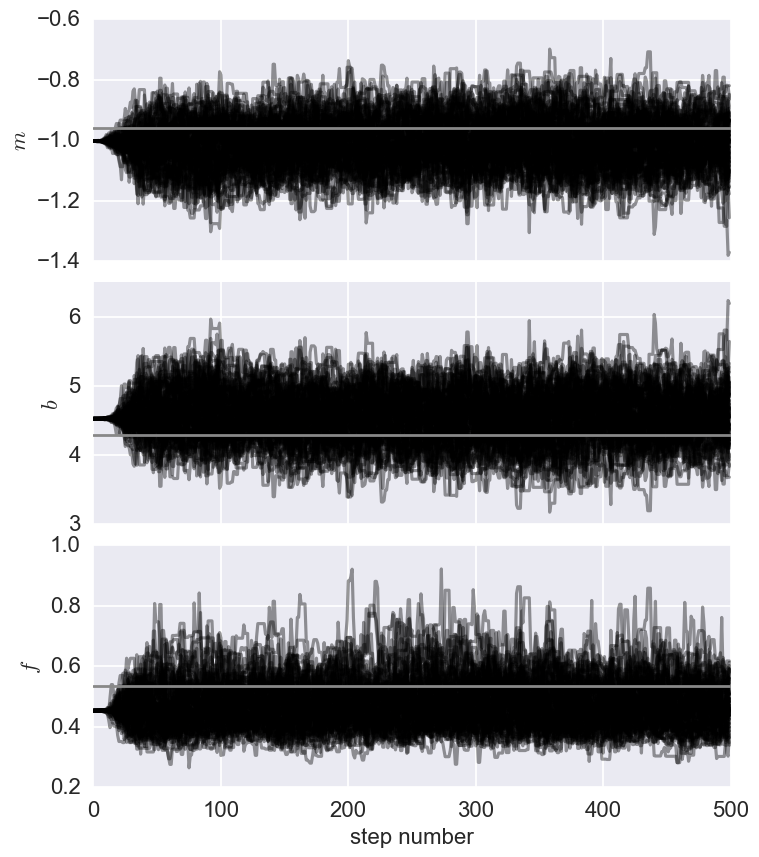

In [29]:
pl.clf()
fig, axes = pl.subplots(3, 1, sharex=True, figsize=(8, 9))
axes[0].plot(sampler.chain[:, :, 0].T, color="k", alpha=0.4)
axes[0].yaxis.set_major_locator(MaxNLocator(5))
axes[0].axhline(m_true, color="#888888", lw=2)
axes[0].set_ylabel("$m$")

axes[1].plot(sampler.chain[:, :, 1].T, color="k", alpha=0.4)
axes[1].yaxis.set_major_locator(MaxNLocator(5))
axes[1].axhline(b_true, color="#888888", lw=2)
axes[1].set_ylabel("$b$")

axes[2].plot(np.exp(sampler.chain[:, :, 2]).T, color="k", alpha=0.4)
axes[2].yaxis.set_major_locator(MaxNLocator(5))
axes[2].axhline(f_true, color="#888888", lw=2)
axes[2].set_ylabel("$f$")
axes[2].set_xlabel("step number")

fig.tight_layout(h_pad=0.0)
fig.savefig("line-time.png")

MCMC result:
    m = -1.00919470505 +0.0756055271126 -0.0760895694718 (truth: -0.9594)
    b = 4.55371397375 +0.348558295529 -0.345533075727 (truth: 4.294)
    f = 0.462521091512 +0.0790486734213 -0.0624573345471 (truth: 0.534)



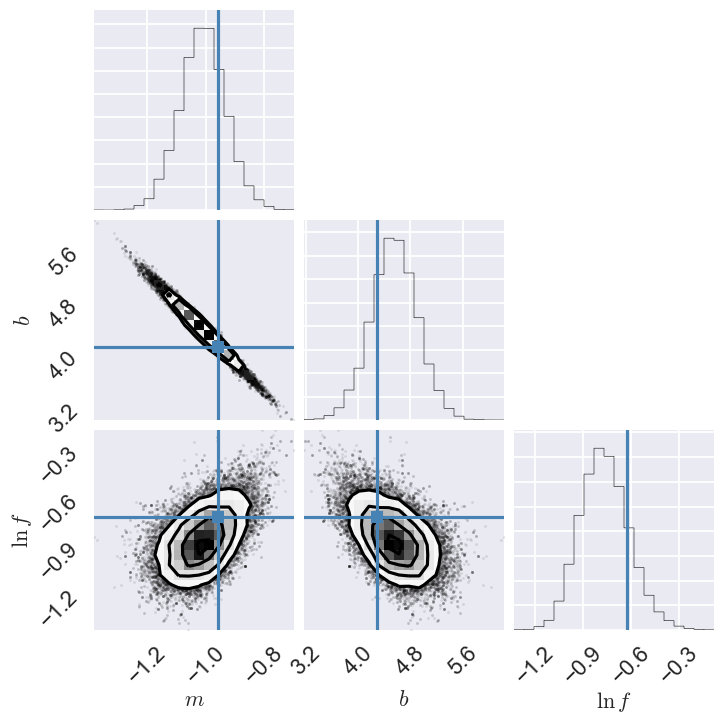

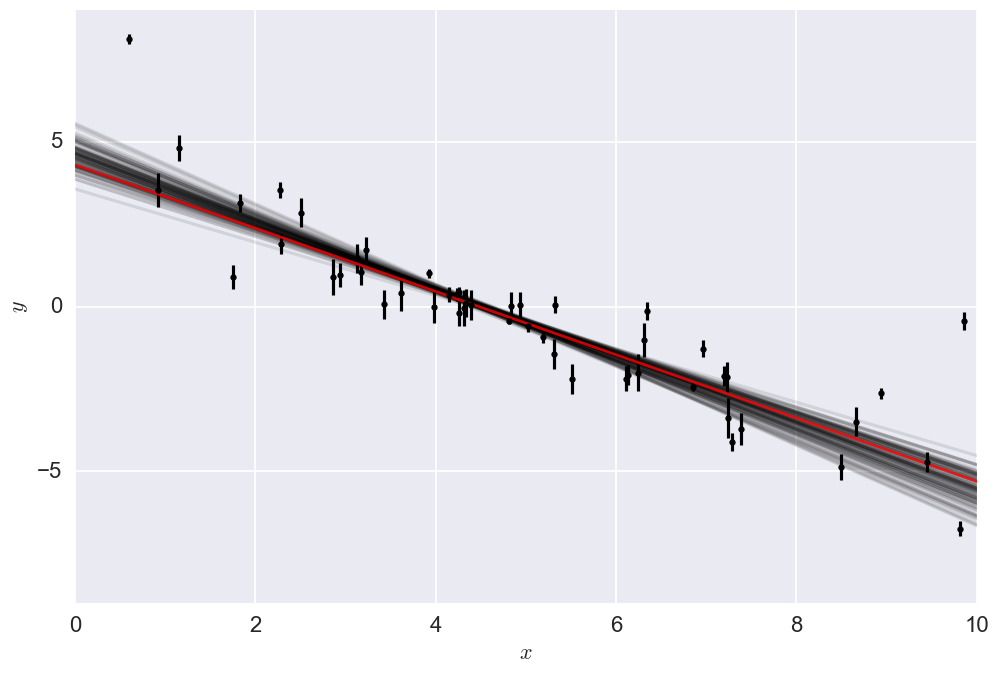

In [30]:
# Make the triangle plot.
burnin = 50
samples = sampler.chain[:, burnin:, :].reshape((-1, ndim))

fig = corner.corner(samples, labels=["$m$", "$b$", "$\ln\,f$"],
                      truths=[m_true, b_true, np.log(f_true)])
fig.savefig("line-triangle.png")

# Plot some samples onto the data.
pl.figure()
for m, b, lnf in samples[np.random.randint(len(samples), size=100)]:
    pl.plot(xl, m*xl+b, color="k", alpha=0.1)
pl.plot(xl, m_true*xl+b_true, color="r", lw=2, alpha=0.8)
pl.errorbar(x, y, yerr=yerr, fmt=".k")
pl.ylim(-9, 9)
pl.xlabel("$x$")
pl.ylabel("$y$")
pl.tight_layout()
pl.savefig("line-mcmc.png")

# Compute the quantiles.
samples[:, 2] = np.exp(samples[:, 2])
m_mcmc, b_mcmc, f_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples, [16, 50, 84],
                                                axis=0)))
print("""MCMC result:
    m = {0[0]} +{0[1]} -{0[2]} (truth: {1})
    b = {2[0]} +{2[1]} -{2[2]} (truth: {3})
    f = {4[0]} +{4[1]} -{4[2]} (truth: {5})
""".format(m_mcmc, m_true, b_mcmc, b_true, f_mcmc, f_true))

In [31]:
analysis_df = pd.read_csv('~/Dropbox/Gaia/analysis_rrl.csv', delim_whitespace=True)

In [32]:
analysis_df

,Name,Period,Type,mag_3p6,err_3p6,amp_3p6,mag_4p5,err_4p5,amp_4p5,RA_ICRS,...,A36,A45,M_3p6,M_4p5,e_M_3p6_gks,e_M_4p5_gks,e_M_3p6_tgas,e_M_4p5_tgas,log_P,logP_f
0,ABUma,0.600,ab,9.598,0.003,0.171,9.587,0.003,0.177,182.810685,...,99.99,99.99,-0.559585,-0.570585,0.212911,0.217097,0.305118,0.311115,-0.221849,-0.221849
1,AMTuc,0.406,c,10.602,0.002,0.127,10.565,0.002,0.142,19.627973,...,99.99,99.99,0.249095,0.212095,0.082488,0.070236,0.119539,0.101783,-0.391474,-0.264474
2,ANSer,0.522,ab,9.801,0.004,0.289,9.795,0.004,0.299,238.379390,...,99.99,99.99,-0.766546,-0.772546,0.264187,0.266255,0.371691,0.374600,-0.282329,-0.282329
3,AVPeg,0.390,ab,9.332,0.004,0.281,9.329,0.004,0.281,328.011708,...,99.99,99.99,0.255457,0.252457,0.128756,0.127244,0.195205,0.192913,-0.408935,-0.408935
4,BHPeg,0.641,ab,9.002,0.003,0.237,8.982,0.003,0.236,343.254215,...,99.99,99.99,-0.267360,-0.287360,0.115538,0.124181,0.178814,0.192190,-0.193142,-0.193142
5,BXLeo,0.363,c,10.678,0.002,0.107,10.670,0.002,0.122,174.508478,...,99.99,99.99,-0.700621,-0.708621,0.159093,0.160910,0.225773,0.228351,-0.440093,-0.313093
6,CSEri,0.311,c,8.126,0.002,0.117,8.110,0.002,0.117,39.274539,...,99.99,99.99,-0.201731,-0.217731,0.143544,0.154929,0.217625,0.234886,-0.507240,-0.380240
7,DXDel,0.473,ab,8.653,0.004,0.249,8.641,0.004,0.258,311.868205,...,99.99,99.99,-0.246460,-0.258460,0.126285,0.132434,0.195448,0.204964,-0.325139,-0.325139
8,HKPup,0.734,ab,9.884,0.004,0.252,9.854,0.004,0.257,116.195095,...,99.99,99.99,-1.494621,-1.524621,0.308615,0.314809,0.447234,0.456211,-0.134304,-0.134304
9,MTTel,0.317,c,8.078,0.002,0.126,8.064,0.002,0.111,285.550322,...,99.99,99.99,-1.145320,-1.159320,0.795056,0.804775,1.102501,1.115977,-0.498941,-0.371941


In [118]:
ab_df = analysis_df.where(analysis_df.Type=='ab').dropna(axis=0, how='all')
ab_df = ab_df.reset_index(drop=True)

x = ab_df.log_P.values
y = ab_df.M_3p6.values
yerr = ab_df.e_M_3p6_gks.values

m_true = -2.5
b_true = -0.75
f_true = 0.65

## m_true, b_true, f_true are the initial guesses

In [119]:
# Do the least-squares fit and compute the uncertainties.
A = np.vstack((np.ones_like(x), x)).T
C = np.diag(yerr * yerr)
cov = np.linalg.inv(np.dot(A.T, np.linalg.solve(C, A)))
b_ls, m_ls = np.dot(cov, np.dot(A.T, np.linalg.solve(C, y)))
print("""Least-squares results:
    m = {0} ± {1} (truth: {2})
    b = {3} ± {4} (truth: {5})
""".format(m_ls, np.sqrt(cov[1, 1]), m_true, b_ls, np.sqrt(cov[0, 0]), b_true))

Least-squares results:
    m = -2.52452164207 ± 0.499667580405 (truth: -2.5)
    b = -0.859349918185 ± 0.159485744597 (truth: -0.75)



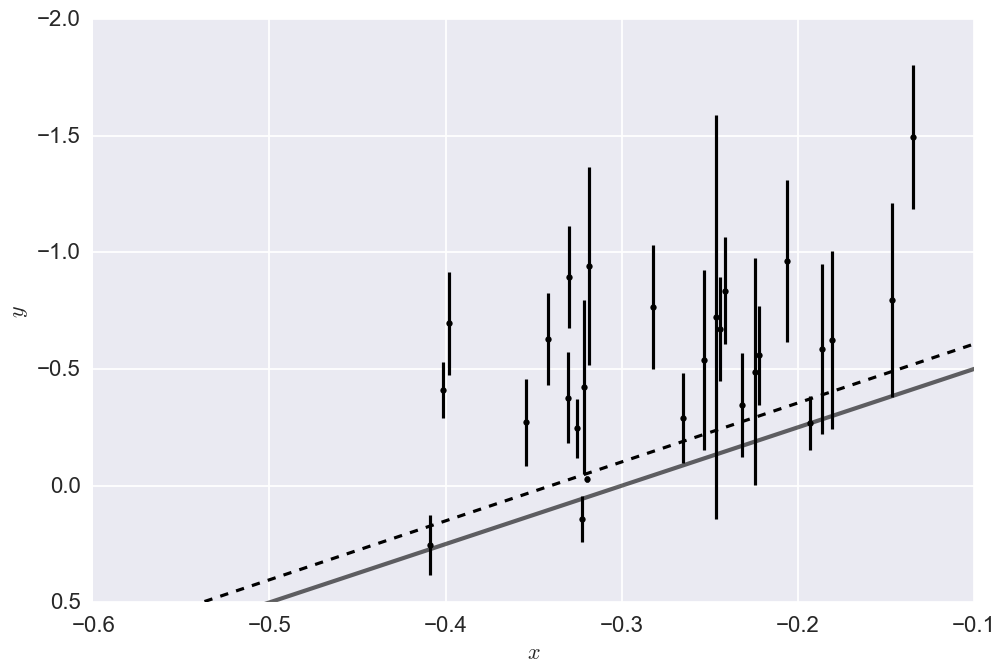

In [120]:
# Plot the least-squares result.
xl = np.arange(-1, 0.1, 0.1)
pl.errorbar(x, y, yerr=yerr, fmt=".k")
pl.plot(xl, m_true*xl+b_true, "k", lw=3, alpha=0.6)
pl.xlabel("$x$")
pl.ylabel("$y$")
pl.tight_layout()
pl.xlim(-0.6, -0.1)
pl.ylim(0.5,-2.0)
pl.plot(xl, m_ls*xl+b_ls, "--k")


In [121]:
# Find the maximum likelihood value.
chi2 = lambda *args: -2 * lnlike(*args)
result = op.minimize(chi2, [m_true, b_true, np.log(f_true)], args=(x, y, yerr))
m_ml, b_ml, lnf_ml = result["x"]
print("""Maximum likelihood result:
    m = {0} (truth: {1})
    b = {2} (truth: {3})
    f = {4} (truth: {5})
""".format(m_ml, m_true, b_ml, b_true, np.exp(lnf_ml), f_true))

Maximum likelihood result:
    m = -1.05561059697 (truth: -2.5)
    b = -0.754465658663 (truth: -0.75)
    f = 0.657900116926 (truth: 0.65)



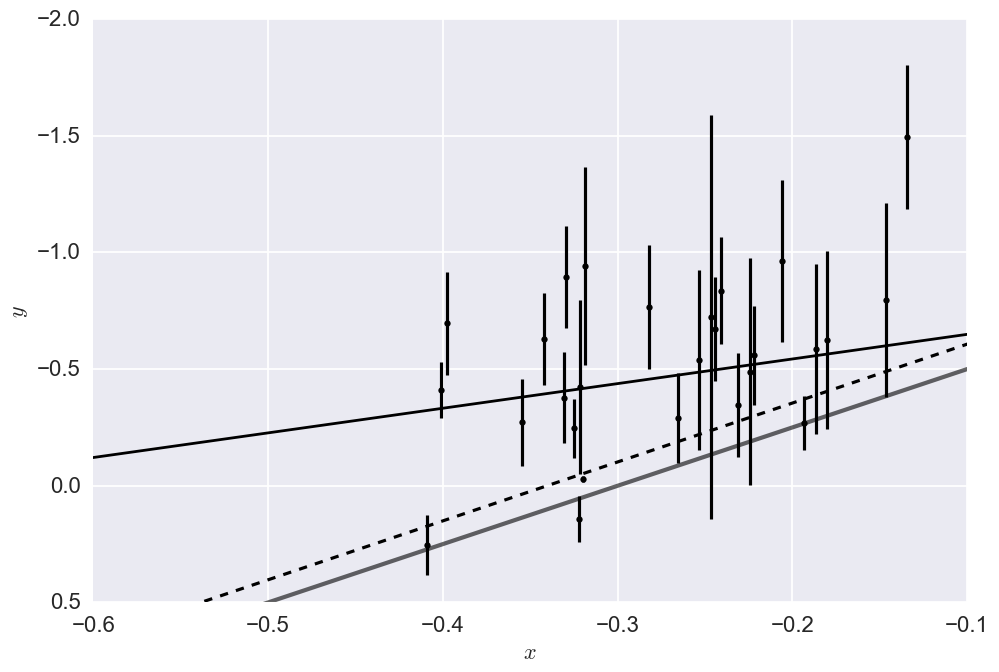

In [122]:
# Plot the maximum likelihood result.
pl.errorbar(x, y, yerr=yerr, fmt=".k")
pl.plot(xl, m_true*xl+b_true, "k", lw=3, alpha=0.6)
pl.ylim(-9, 9)
pl.xlabel("$x$")
pl.ylabel("$y$")
pl.xlim(-0.6, -0.1)
pl.ylim(0.5,-2.0)
pl.tight_layout()
pl.plot(xl, m_ls*xl+b_ls, "--k")
pl.plot(xl, m_ml*xl+b_ml, "k", lw=2)
pl.savefig("line-max-likelihood.png")

In [123]:
ndim, nwalkers = 3, 300
pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x, y, yerr))

In [124]:
# Clear and run the production chain.
print("Running MCMC...")
sampler.run_mcmc(pos, 500, rstate0=np.random.get_state())
print("Done.")

Running MCMC...
Done.


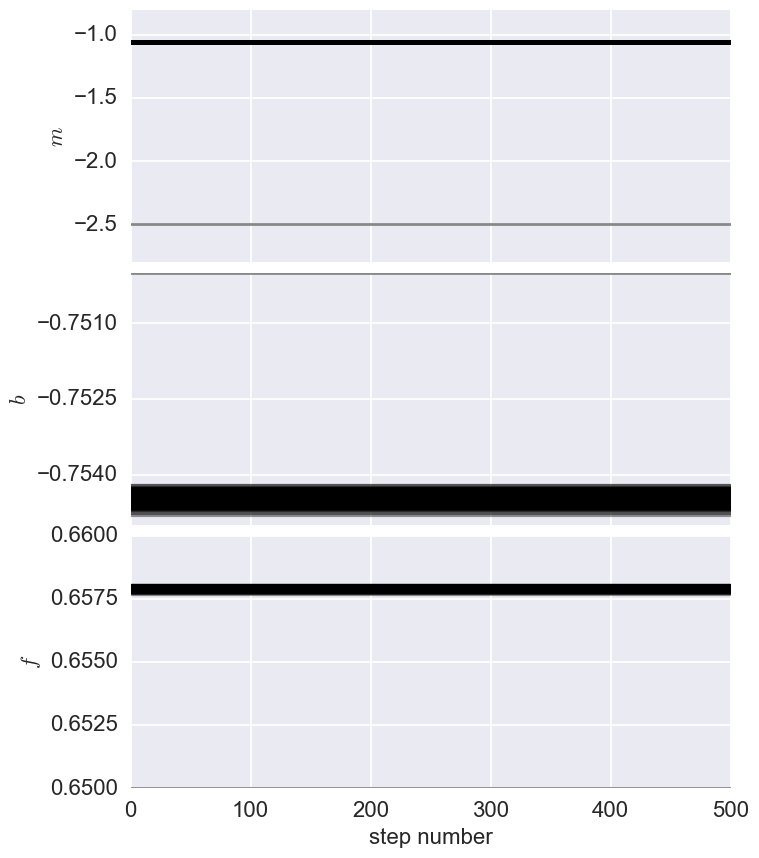

In [125]:
pl.clf()
fig, axes = pl.subplots(3, 1, sharex=True, figsize=(8, 9))
axes[0].plot(sampler.chain[:, :, 0].T, color="k", alpha=0.4)
axes[0].yaxis.set_major_locator(MaxNLocator(5))
axes[0].axhline(m_true, color="#888888", lw=2)
axes[0].set_ylabel("$m$")

axes[1].plot(sampler.chain[:, :, 1].T, color="k", alpha=0.4)
axes[1].yaxis.set_major_locator(MaxNLocator(5))
axes[1].axhline(b_true, color="#888888", lw=2)
axes[1].set_ylabel("$b$")

axes[2].plot(np.exp(sampler.chain[:, :, 2]).T, color="k", alpha=0.4)
axes[2].yaxis.set_major_locator(MaxNLocator(5))
axes[2].axhline(f_true, color="#888888", lw=2)
axes[2].set_ylabel("$f$")
axes[2].set_xlabel("step number")

fig.tight_layout(h_pad=0.0)
fig.savefig("line-time.png")

MCMC result:
    m = -1.05560911096 +9.98648814807e-05 -9.75316181351e-05 (truth: -2.5)
    b = -0.754459094213 +9.68757680304e-05 -0.000111309389197 (truth: -0.75)
    f = 0.657903443547 +6.5626255556e-05 -6.54706114823e-05 (truth: 0.65)



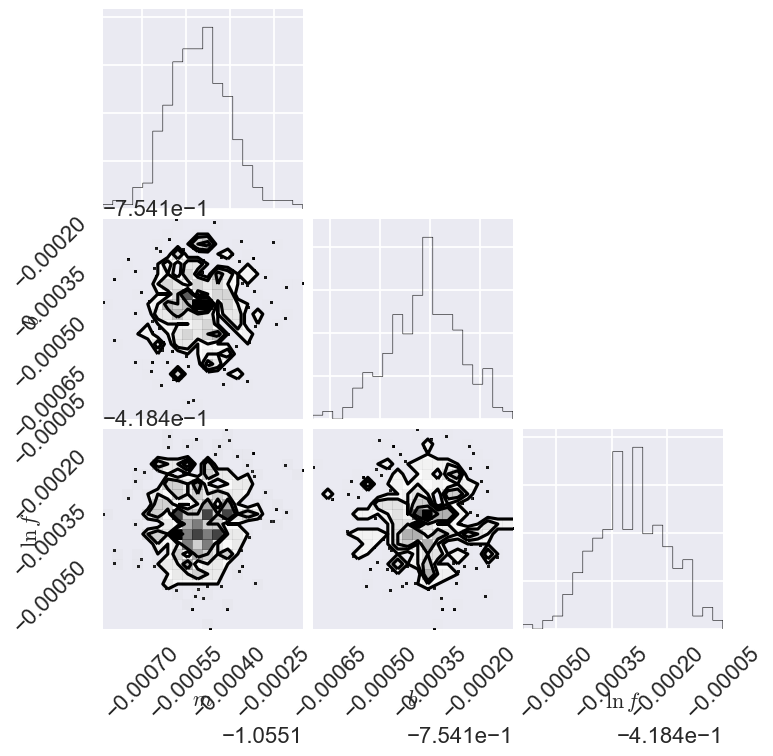

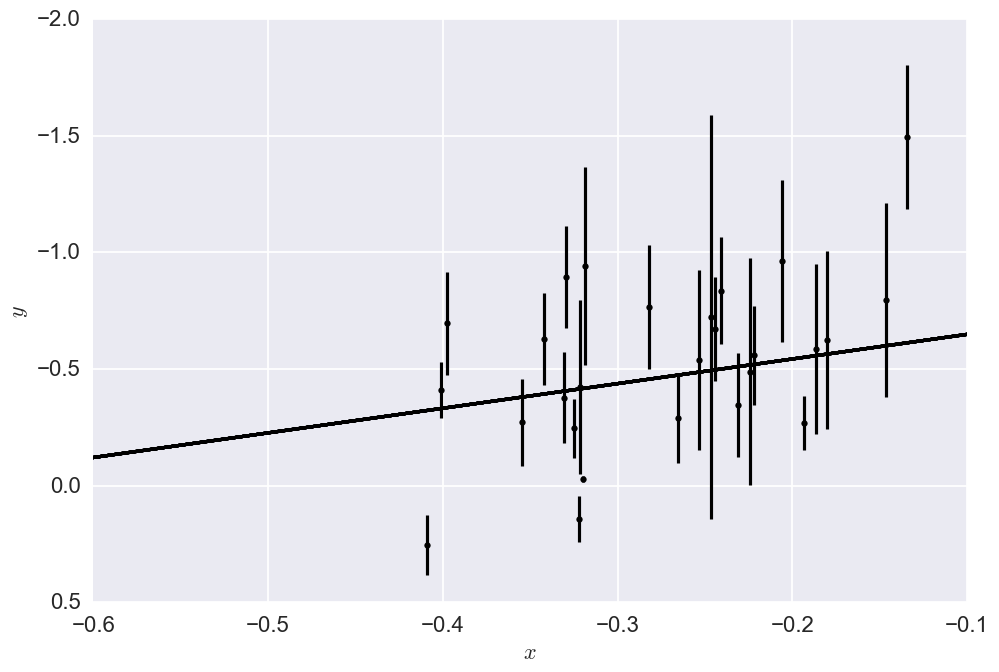

In [126]:
# Make the triangle plot.
burnin = 50
samples = sampler.chain[:, burnin:, :].reshape((-1, ndim))

fig = corner.corner(samples, labels=["$m$", "$b$", "$\ln\,f$"],
                      truths=[m_true, b_true, np.log(f_true)])
fig.savefig("line-triangle.png")

# Plot some samples onto the data.
pl.figure()
for m, b, lnf in samples[np.random.randint(len(samples), size=100)]:
    pl.plot(xl, m*xl+b, color="k", alpha=0.1)
#pl.plot(xl, m_true*xl+b_true, color="r", lw=2, alpha=0.8)
pl.errorbar(x, y, yerr=yerr, fmt=".k")
pl.ylim(-9, 9)
pl.xlabel("$x$")
pl.ylabel("$y$")
pl.xlim(-0.6, -0.1)
pl.ylim(0.5,-2.0)
pl.tight_layout()
pl.savefig("line-mcmc.png")

# Compute the quantiles.
samples[:, 2] = np.exp(samples[:, 2])
m_mcmc, b_mcmc, f_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples, [16, 50, 84],
                                                axis=0)))
print("""MCMC result:
    m = {0[0]} +{0[1]} -{0[2]} (truth: {1})
    b = {2[0]} +{2[1]} -{2[2]} (truth: {3})
    f = {4[0]} +{4[1]} -{4[2]} (truth: {5})
""".format(m_mcmc, m_true, b_mcmc, b_true, f_mcmc, f_true))

In [127]:
dist = y - (m_mcmc[0]*x+b_mcmc[0])

In [128]:
np.mean(dist), np.std(dist)

(-0.072039291457669449, 0.3243815537059726)